# Libs 

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import boxcox
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet,SGDRegressor
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
sns.set(rc={'figure.figsize':(18,6)},style='darkgrid')
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from datasist.structdata import detect_outliers
import statsmodels.api as sm

# Insurance project

In [2]:
#Getting Data
df = pd.read_csv(r"D:\Datasets\insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [4]:
#Summary Stat
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,1338.0,NaN,NaN,NaN,39.207025,14.04996,18.0,27.0,39.0,51.0,64.0
sex,1338,2,male,676,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bmi,1338.0,NaN,NaN,NaN,30.663397,6.098187,15.96,26.29625,30.4,34.69375,53.13
children,1338.0,NaN,NaN,NaN,1.094918,1.205493,0.0,0.0,1.0,2.0,5.0
smoker,1338,2,no,1064,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region,1338,4,southeast,364,NaN,NaN,NaN,NaN,NaN,NaN,NaN
charges,1338.0,NaN,NaN,NaN,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


### Notes
- Numeric data are approx normaly except charges
- Males are more in the data
- smokers are more in the data
- region southeast is more in the data

## Univariate Analysis

In [5]:
numeric_cols = df.select_dtypes(np.number).columns
len(numeric_cols)

4

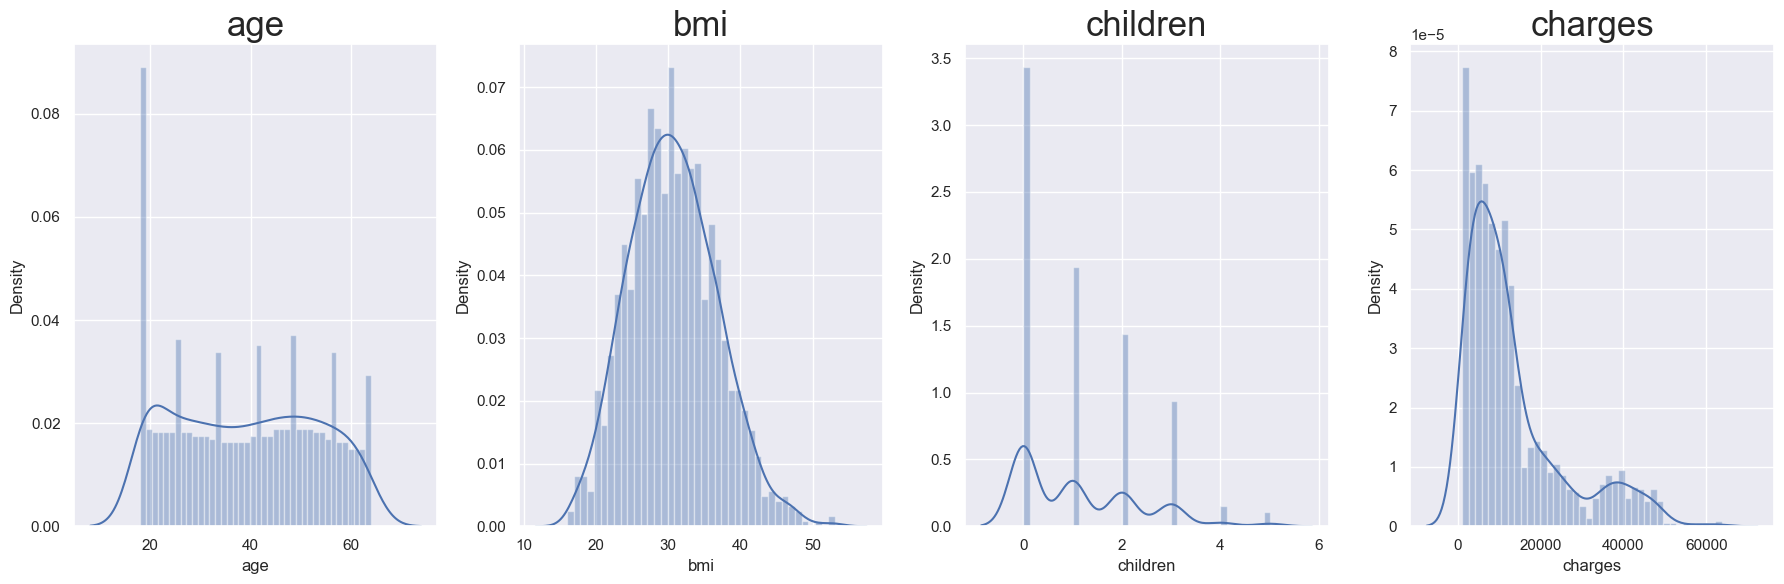

In [6]:
_,axs = plt.subplots(1,4)
for idx,col in enumerate(numeric_cols):
    sns.distplot(df[col],bins=40,ax=axs[idx]).set_title(col,size=25)
plt.tight_layout()
plt.show()

# Bivariate

<Axes: >

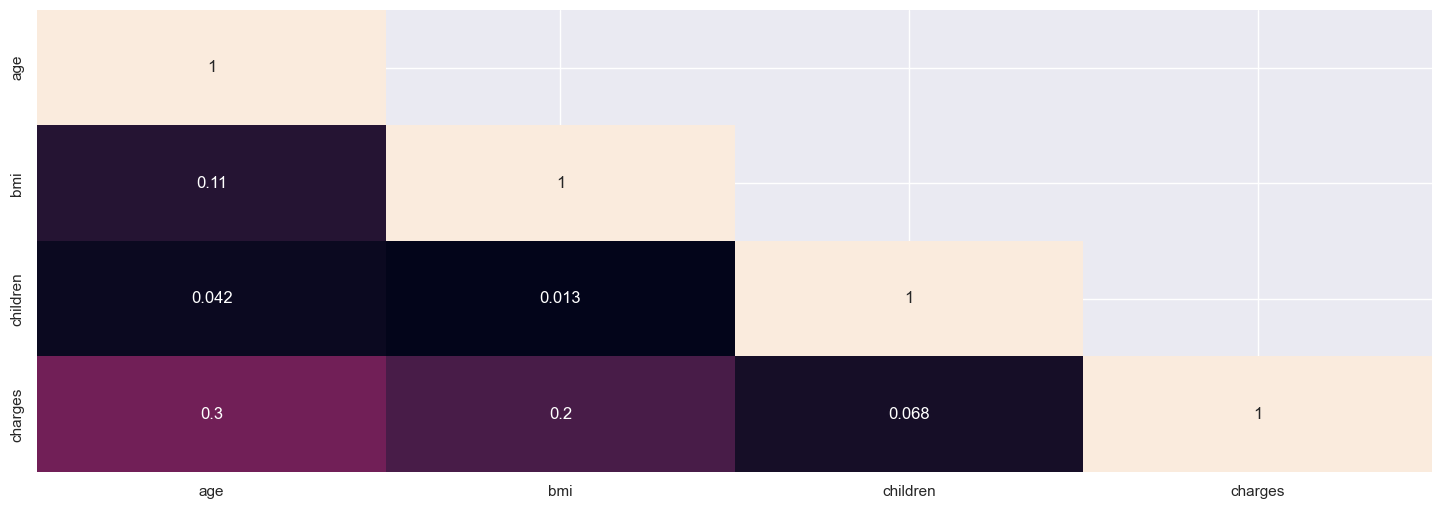

In [7]:
sns.heatmap(data = df.corr(numeric_only=True),
           cmap='rocket',
           annot=True,
           cbar=False,
           mask= np.triu(np.ones_like(df.corr(numeric_only=True),dtype=bool),k=1))

<Axes: xlabel='age', ylabel='charges'>

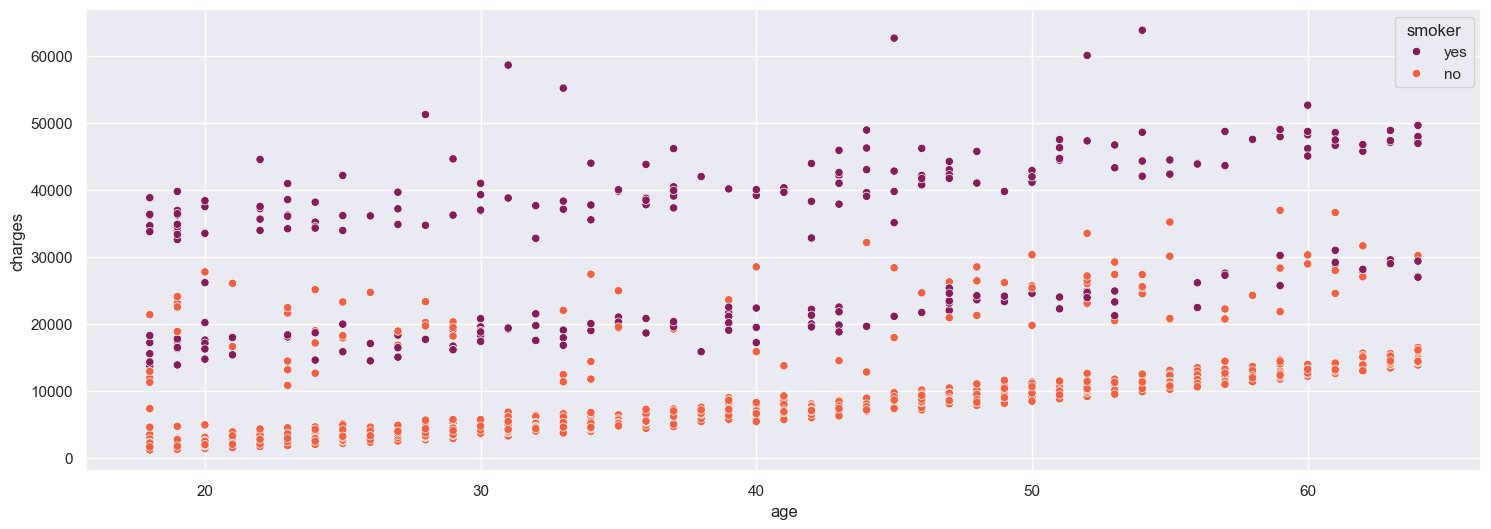

In [8]:
sns.scatterplot(x=df['age'],y=df['charges'],hue=df['smoker'],palette='rocket')

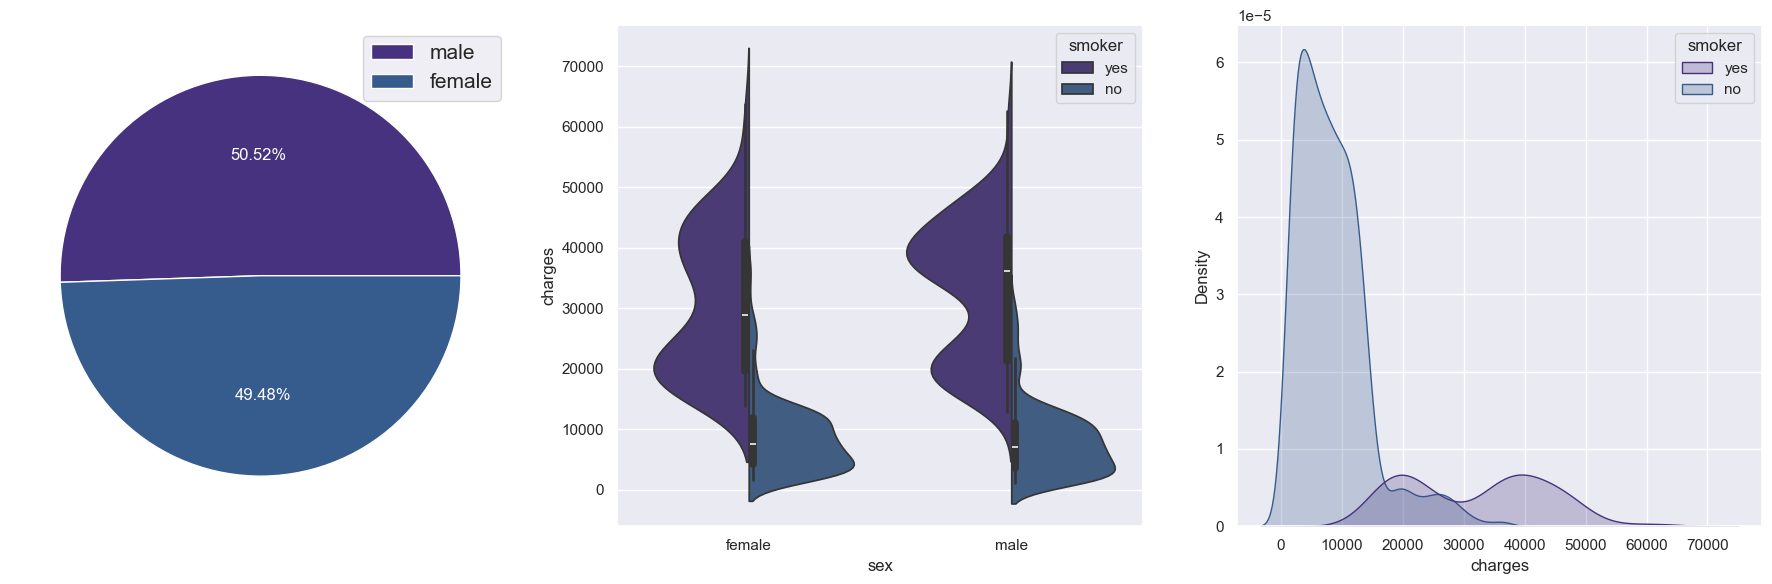

In [9]:
sns.set_palette('viridis')
fig,axs = plt.subplots(1,3)
axs[0].pie(df['sex'].value_counts().values.tolist(),
        labels=df['sex'].value_counts().index.tolist(),
          autopct='%.2f%%',
          startangle=0,
          textprops={'color':'white'})
sns.violinplot(data=df,
              x=df['sex'],
              y=df['charges'],hue=df['smoker'],
              split=True,
              ax=axs[1])
sns.kdeplot(data=df,x='charges',hue='smoker',ax=axs[2],shade=True)
axs[0].legend(labels=df['sex'].value_counts().index.tolist(),fontsize=15)
plt.tight_layout()
plt.show()

<Figure size 200x200 with 0 Axes>

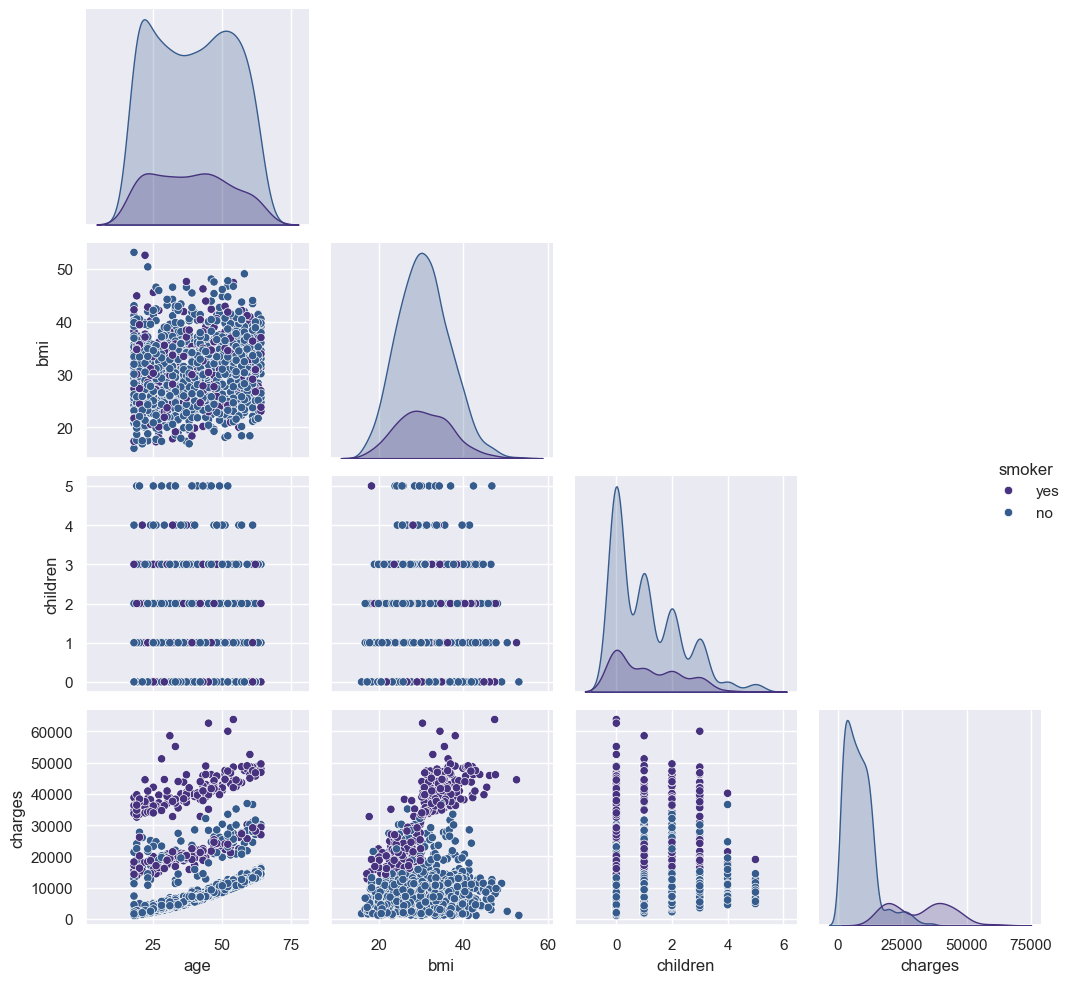

In [10]:
plt.figure(figsize=(2,2))
sns.pairplot(data=df,corner=True,hue='smoker')
plt.tight_layout()
plt.show()

In [11]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


<Axes: xlabel='region'>

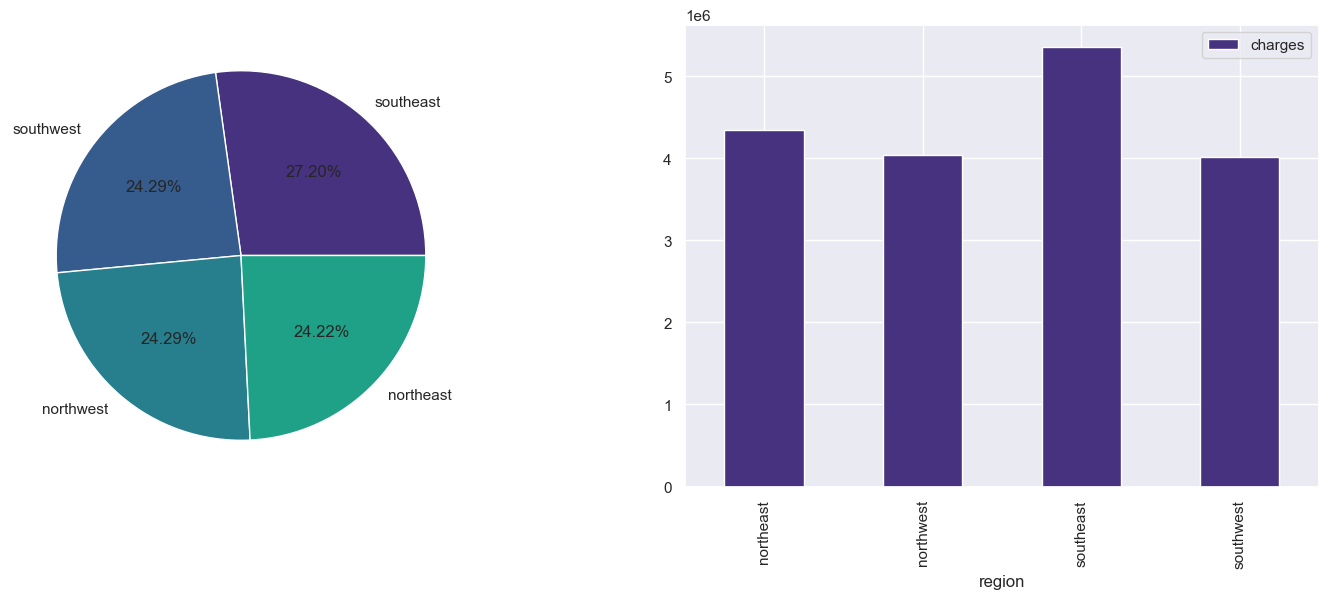

In [12]:
_,axs = plt.subplots(1,2)
axs[0].pie(df['region'].value_counts().values.tolist(),labels=df['region'].value_counts().index.tolist(),autopct='%.2f%%')
df.groupby('region')[['charges']].sum().plot(kind='bar',ax=axs[1])

In [13]:
df_2 = pd.get_dummies(data=df,columns=['sex','region','smoker'],drop_first=True,dtype='int8')
df_2.head()

,age,bmi,children,charges,sex_male,region_northwest,region_southeast,region_southwest,smoker_yes
0,19,27.900,0,16884.92400,0,0,0,1,1
1,18,33.770,1,1725.55230,1,0,1,0,0
2,28,33.000,3,4449.46200,1,0,1,0,0
3,33,22.705,0,21984.47061,1,1,0,0,0
4,32,28.880,0,3866.85520,1,1,0,0,0


In [14]:
df_2['charges'] = np.log(df['charges'])

In [15]:
df_2.head()

,age,bmi,children,charges,sex_male,region_northwest,region_southeast,region_southwest,smoker_yes
0,19,27.900,0,9.734176,0,0,0,1,1
1,18,33.770,1,7.453302,1,0,1,0,0
2,28,33.000,3,8.400538,1,0,1,0,0
3,33,22.705,0,9.998092,1,1,0,0,0
4,32,28.880,0,8.260197,1,1,0,0,0


### Model Build

In [16]:
x = df_2.drop('charges',axis=1)
y = df_2['charges']

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, shuffle=True,random_state=10)

In [18]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [19]:
model = LinearRegression()

In [20]:
Kfold_ = KFold(n_splits=5,shuffle=True,random_state=10)

In [21]:
scores_ = cross_val_score(model,x,y,cv=Kfold_,scoring='r2')

In [22]:
scores_

array([0.70556285, 0.755709  , 0.77264392, 0.78698237, 0.78773318])

In [23]:
model.fit(x_train,y_train)

LinearRegression()

In [24]:
y_pred = model.predict(x_test)

In [25]:
r2_score(y_test,y_pred)

0.7055628534219356

In [26]:
np.sqrt(mean_squared_error(y_test,y_pred))

0.48772824965970446

In [27]:
df_2['charges'].std()

0.919527112931093

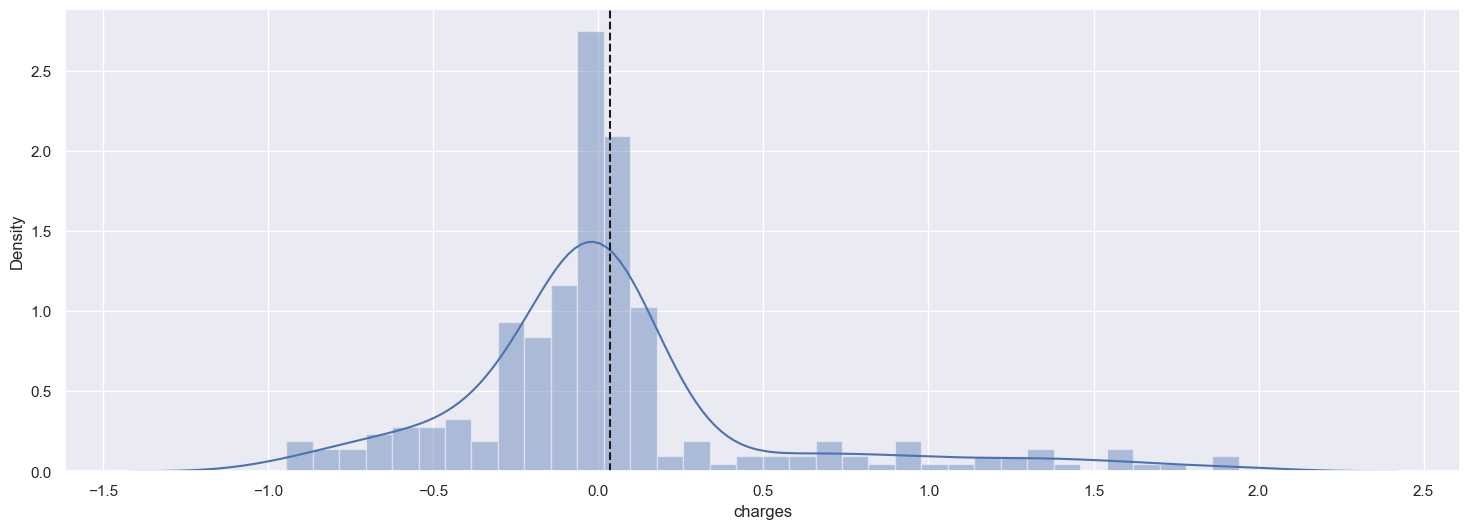

In [28]:
sns.distplot((y_test - y_pred),color='b')
plt.axvline((y_test - y_pred).mean(),color='k',linestyle='--')

<Axes: xlabel='charges'>

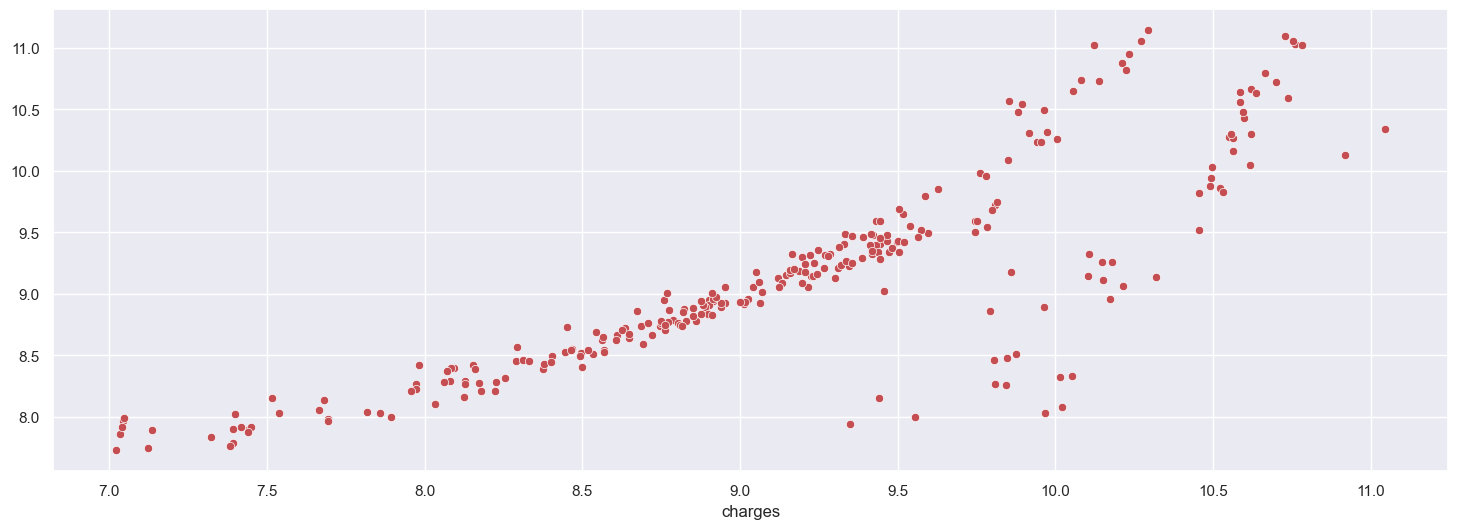

In [29]:
sns.scatterplot(x=y_test,y=y_pred,color='r')

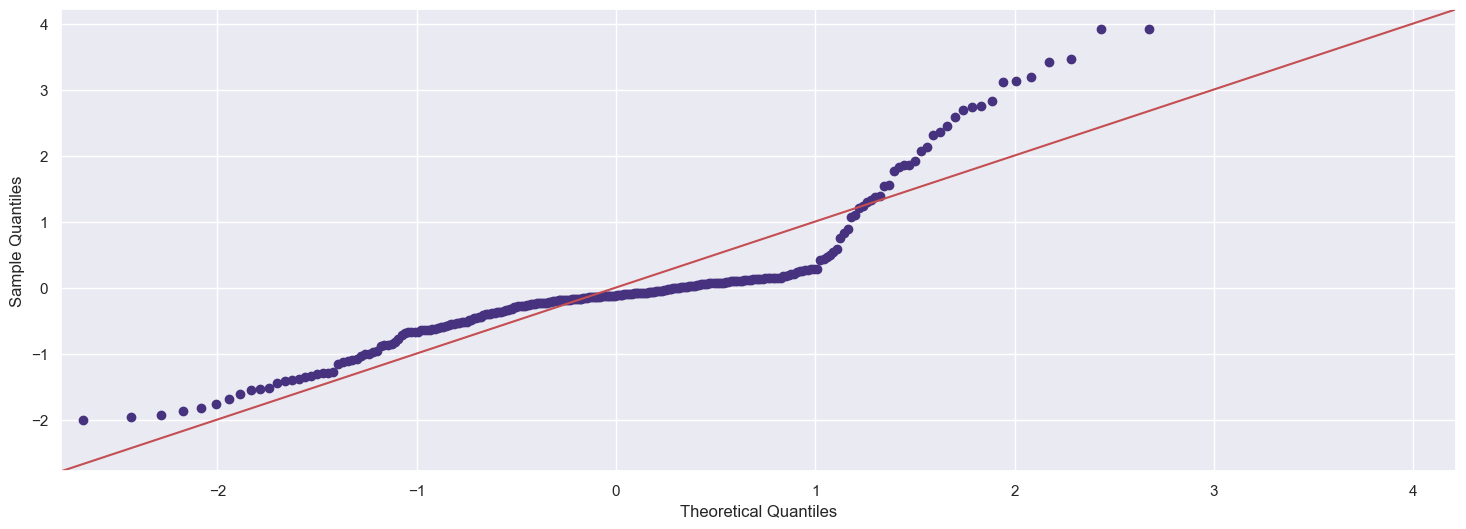

In [30]:
sm.qqplot((y_test - y_pred),fit=True,line='45');

Linear regression gives a poor predictions on our data since : 
- Distribution of residuals is not a normal distribution
- Distribution of residuals is shifted from zero mean
- Scatter plot shows that the relation between residuals is linear